In [36]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

In [37]:
with open('data/data_nash.json') as fi:
    credentials = json.load(fi)
    
with open('data/data_nash_secret.json') as fi:
    credentials_secret = json.load(fi)
    
api_key = credentials['api_key']
api_key_secret = credentials_secret['api_key_secret']

In [38]:
endpoint = "https://data.nashville.gov/resource/2u6v-ujjs.json?$limit=50000"

params = {'$where' : "incident_reported between '2021-01-13T00:00:00.000' and '2021-06-30T00:00:00.000'", 
}

In [39]:
response = requests.get(endpoint, params)
response

<Response [200]>

In [73]:
res = response.json()
res = pd.DataFrame(res, columns=['incident_reported', 'offense_description', 'latitude', 'longitude', 'zip_code'])
res['date_reported'] = res['incident_reported'].str.split("T", expand=True)[0]
res_trimmed = res.drop(columns='incident_reported')
burglary_reports = res_trimmed[res_trimmed['offense_description'].str.contains('BURGLARY')]
burglary_reports.head()

,offense_description,latitude,longitude,zip_code,date_reported
27,BURGLARY- MOTOR VEHICLE,36.13,-86.7,NaN,2021-01-13
51,BURGLARY- MOTOR VEHICLE,36.07,-86.64,NaN,2021-01-13
56,BURGLARY- MOTOR VEHICLE,36.17,-86.78,NaN,2021-01-13
57,BURGLARY- MOTOR VEHICLE,36.17,-86.78,NaN,2021-01-13
98,BURGLARY- MOTOR VEHICLE,36.21,-86.81,NaN,2021-01-13


In [74]:
burglary_reports[['latitude', 'longitude']] = burglary_reports[['latitude', 'longitude']].apply(pd.to_numeric);

burglary_reports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4545 entries, 27 to 48913
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   offense_description  4545 non-null   object 
 1   latitude             4534 non-null   float64
 2   longitude            4534 non-null   float64
 3   zip_code             277 non-null    object 
 4   date_reported        4545 non-null   object 
dtypes: float64(2), object(3)
memory usage: 213.0+ KB


C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [75]:
census_tract = gpd.read_file('data/tl_2019-47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [76]:
print(census_tract.crs)
census_tract.head()

epsg:4269


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


In [77]:
#leg_kwds = {'title': 'Census Tracts', 'loc':'upper left', 
#            'bbox_to_anchor': (0, 0), 'ncol': 9}

#census_tract.plot(column = 'NAME', figsize=(15, 15), edgecolor = 'black',
#                 legend = True, legend_kwds = leg_kwds, cmap = 'terrain')

In [78]:
burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,
                                                                      x.latitude)),
                                                     axis=1)

burglary_reports.head()

C:\Users\Conrad\AppData\Local\Temp/ipykernel_27716/3948901756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,


,offense_description,latitude,longitude,zip_code,date_reported,geometry
27,BURGLARY- MOTOR VEHICLE,36.13,-86.70,NaN,2021-01-13,POINT (-86.7 36.13)
51,BURGLARY- MOTOR VEHICLE,36.07,-86.64,NaN,2021-01-13,POINT (-86.64 36.07)
56,BURGLARY- MOTOR VEHICLE,36.17,-86.78,NaN,2021-01-13,POINT (-86.78 36.17)
57,BURGLARY- MOTOR VEHICLE,36.17,-86.78,NaN,2021-01-13,POINT (-86.78 36.17)
98,BURGLARY- MOTOR VEHICLE,36.21,-86.81,NaN,2021-01-13,POINT (-86.81 36.21)


In [79]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,
                               crs=census_tract.crs,
                               geometry = burglary_reports['geometry'])

In [80]:
census_tract = census_tract[['COUNTYFP', 'NAME', 'geometry']]

In [83]:
burglary_by_tract = gpd.sjoin(burglary_geo, census_tract, op = 'within')

In [105]:
burglary_by_tract.drop_duplicates(subset='geometry', inplace=True)
burglary_by_tract

,offense_description,latitude,longitude,zip_code,date_reported,geometry,index_right,COUNTYFP,NAME
27,BURGLARY- MOTOR VEHICLE,36.130,-86.70,NaN,2021-01-13,POINT (-86.70000 36.13000),415,037,158.04
40978,BURGLARY- AGGRAVATED,36.129,-86.70,37217,2021-06-04,POINT (-86.70000 36.12900),415,037,158.04
51,BURGLARY- MOTOR VEHICLE,36.070,-86.64,NaN,2021-01-13,POINT (-86.64000 36.07000),429,037,156.26
22287,BURGLARY- AGGRAVATED,36.070,-86.65,NaN,2021-04-04,POINT (-86.65000 36.07000),429,037,156.26
26308,BURGLARY- MOTOR VEHICLE,36.080,-86.65,NaN,2021-04-18,POINT (-86.65000 36.08000),429,037,156.26
...,...,...,...,...,...,...,...,...,...
28551,BURGLARY- MOTOR VEHICLE,36.370,-86.89,NaN,2021-04-26,POINT (-86.89000 36.37000),36,037,101.03
39210,BURGLARY- MOTOR VEHICLE,36.330,-86.85,NaN,2021-05-30,POINT (-86.85000 36.33000),36,037,101.03
33851,BURGLARY- MOTOR VEHICLE,36.100,-86.80,NaN,2021-05-13,POINT (-86.80000 36.10000),1111,037,177.02
44517,BURGLARY- AGGRAVATED,36.090,-86.80,NaN,2021-06-16,POINT (-86.80000 36.09000),1111,037,177.02


In [106]:
burglaries_in_195 = burglary_by_tract.loc[burglary_by_tract['NAME'] == '195']
burglaries_in_195

,offense_description,latitude,longitude,zip_code,date_reported,geometry,index_right,COUNTYFP,NAME
56,BURGLARY- MOTOR VEHICLE,36.170,-86.780,NaN,2021-01-13,POINT (-86.78000 36.17000),123,037,195
103,BURGLARY- MOTOR VEHICLE,36.160,-86.770,NaN,2021-01-13,POINT (-86.77000 36.16000),123,037,195
253,BURGLARY- MOTOR VEHICLE,36.160,-86.780,NaN,2021-01-13,POINT (-86.78000 36.16000),123,037,195
976,BURGLARY- MOTOR VEHICLE,36.150,-86.800,NaN,2021-01-16,POINT (-86.80000 36.15000),123,037,195
1259,BURGLARY- MOTOR VEHICLE,36.152,-86.798,37203,2021-01-17,POINT (-86.79800 36.15200),123,037,195
1759,BURGLARY (NON HABITATION),36.150,-86.780,NaN,2021-01-19,POINT (-86.78000 36.15000),123,037,195
3279,BURGLARY- MOTOR VEHICLE,36.160,-86.790,NaN,2021-01-24,POINT (-86.79000 36.16000),123,037,195
10083,BURGLARY- MOTOR VEHICLE,36.158,-86.766,37210,2021-02-17,POINT (-86.76600 36.15800),123,037,195
10126,BURGLARY- MOTOR VEHICLE,36.152,-86.773,37203,2021-02-18,POINT (-86.77300 36.15200),123,037,195
19020,BURGLARY- MOTOR VEHICLE,36.153,-86.789,37203,2021-03-22,POINT (-86.78900 36.15300),123,037,195


In [107]:
polygon195 = census_tract.loc[census_tract['NAME']=='195'] 
polygon195

,COUNTYFP,NAME,geometry
123,037,195,"POLYGON ((-86.80272 36.15248, -86.80083 36.153..."


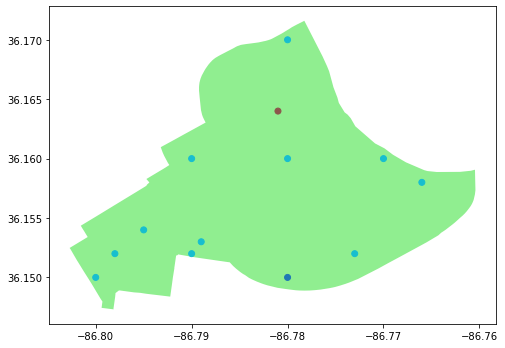

In [108]:
ax = polygon195.plot(figsize = (8, 10), color = 'lightgreen')
burglaries_in_195.plot(ax = ax, column = 'offense_description')
plt.show();